In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
df = pd.read_csv('../../data/artists_data.csv', sep='\t')
df.head()

,id,name,genres,followers,popularity
0,1LEtM3AleYg1xabW6CRkpi,Đen,"indie viet, v-pop, vietnamese hip hop, vietnam...",2899329,59
1,3rjcQ5VIWCN4q7UFetzdeO,JustaTee,"v-pop, vietnamese hip hop, vietnamese melodic rap",618216,55
2,5fa13NJjmn2uQ3dxZDi2Ge,Bich Phuong,v-pop,1182922,46
3,0qkGQFUrj8ERPAZcdpa79j,Phuc Du,v-pop,16509,46
4,71Cy7nzbfpuGJAS5FGxm93,Khoi Vu,vietnamese hip hop,25307,43


### <b><u>Question</u>: What are the 10 best rated genres?</b>

In [98]:
song_df = pd.read_csv('../../data/songs_data.tsv', sep='\t')
song_df.head()

,id,name,artist,genres,artist_followers,artist_popularity,markets,album,released_date,album_popularity,duration,explicit,popularity
0,1RDvyOk4WtPCtoqciJwVn8,Dreamers [Music from the FIFA World Cup Qatar ...,"Jung Kook,BTS,FIFA Sound","k-pop boy group,k-pop","5382641,58715441,167875","80,92,77",183,Dreamers [Music from the FIFA World Cup Qatar ...,2022-11-20,81,201391,False,92
1,6A1IbMKwjvXibcrU1sdqKH,Em Là,"MONO,Onionn",NaN,"100123,2809","54,55",182,22,2022-08-18,60,197333,False,62
2,7bFFUPBiF15n8m8RziqS4o,dự báo thời tiết hôm nay mưa,GREY D,v-pop,39690,56,182,dự báo thời tiết hôm nay mưa – Maxi Single,2022-11-22,52,281493,False,62
3,4QjxvzEFwb63NZ1pp3wvHy,Chết Trong Em,Thịnh Suy,"vietnamese singer-songwriter,v-pop",359817,54,183,Chết Trong Em,2022-10-31,50,256663,False,62
4,5p8ThxM2OhJ0igfxkz0Z1q,Wild Flower (with youjeen),RM,k-rap,12005881,81,183,Indigo,2022-12-02,85,273499,False,88


In [99]:
df = song_df.dropna()
df['genres'].update(df['genres'].str.split(','))
genre_popularity = df.explode('genres').loc[:, ['genres', 'popularity']].reset_index(drop=True)
genre_popularity

/tmp/ipykernel_4153/2442345513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres'].update(df['genres'].str.split(','))


,genres,popularity
0,k-pop boy group,92
1,k-pop,92
2,v-pop,62
3,vietnamese singer-songwriter,62
4,v-pop,62
...,...,...
7725,nueva musica mexicana,60
7726,arrocha,60
7727,sertanejo universitario,60
7728,sertanejo pop,60


In [100]:
genre_trend = pd.pivot_table(genre_popularity, values='popularity', index='genres', aggfunc={'genres':'count', 'popularity': np.mean}).round(2)
genre_trend = genre_trend.rename(columns={'genres': 'occurences'})
genre_trend.sort_values(by=['occurences', 'popularity'])

,occurences,popularity
genres,,
alternative pop rock,1,0.00
indie emo,1,0.00
nu disco,1,0.00
queens hip hop,1,0.00
deep euro house,1,1.00
...,...,...
uk pop,247,13.19
vietnamese hip hop,317,41.89
dance pop,351,34.25


<AxesSubplot:xlabel='occurences', ylabel='popularity'>

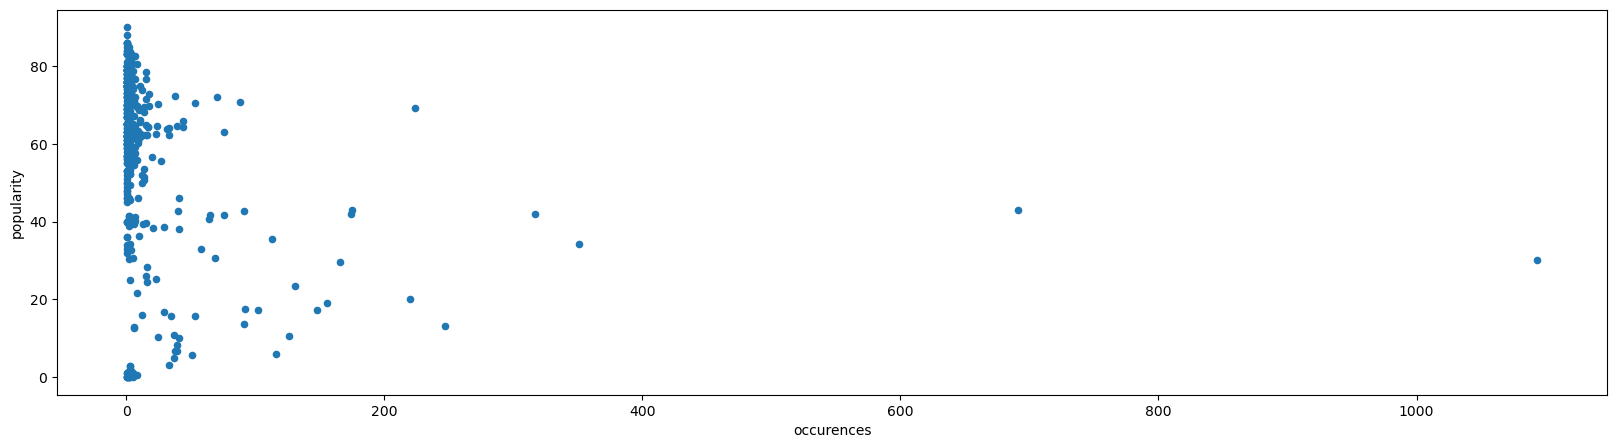

In [101]:
genre_trend.plot.scatter(x='occurences', y='popularity', figsize=(20,5))

In [102]:
def MinMaxScaler0_100(s):
    return (100*(s - s.min()))/(s.max()-s.min())

In [103]:
genre_trend['occurences'] = MinMaxScaler0_100(genre_trend['occurences'])
genre_trend['popularity'] = MinMaxScaler0_100(genre_trend['popularity'])
genre_trend = genre_trend.rename(columns={'occurences': 'occurences_scaled', 'popularity': 'popularity_scaled'})

In [104]:
genre_trend.sort_values(by='occurences_scaled').round(2)

,occurences_scaled,popularity_scaled
genres,,
a cappella,0.00,77.78
ninja,0.00,80.00
electronic trap,0.00,84.44
nightcore,0.00,67.78
emoplugg,0.00,81.11
...,...,...
uk pop,22.53,14.66
vietnamese hip hop,28.94,46.54
dance pop,32.05,38.06


In [105]:
genre_trend['rating'] = np.sqrt(genre_trend['occurences_scaled'] * genre_trend['popularity_scaled'])
genre_trend['rating'] = MinMaxScaler0_100(genre_trend['rating'])
genre_trend.sort_values(by='rating')

,occurences_scaled,popularity_scaled,rating
genres,,,
a cappella,0.000000,77.777778,0.000000
eau claire indie,0.000000,87.777778,0.000000
modern salsa,0.000000,87.777778,0.000000
el paso indie,0.000000,76.666667,0.000000
modern country rock,0.000000,82.222222,0.000000
...,...,...,...
dance pop,32.051282,38.055556,60.420773
vietnamese hip hop,28.937729,46.544444,63.492246
k-pop,20.421245,76.844444,68.533339


In [106]:
genre_trend.nlargest(n=10, columns='rating').round(2)

,occurences_scaled,popularity_scaled,rating
genres,,,
pop,100.00,33.41,100.00
v-pop,63.19,47.69,94.97
k-pop,20.42,76.84,68.53
vietnamese hip hop,28.94,46.54,63.49
dance pop,32.05,38.06,60.42
indie viet,15.93,47.72,47.71
vietnamese melodic rap,15.84,46.52,46.97
k-pop boy group,7.97,78.64,43.30
k-pop girl group,6.32,80.08,38.92


<AxesSubplot:ylabel='genres'>

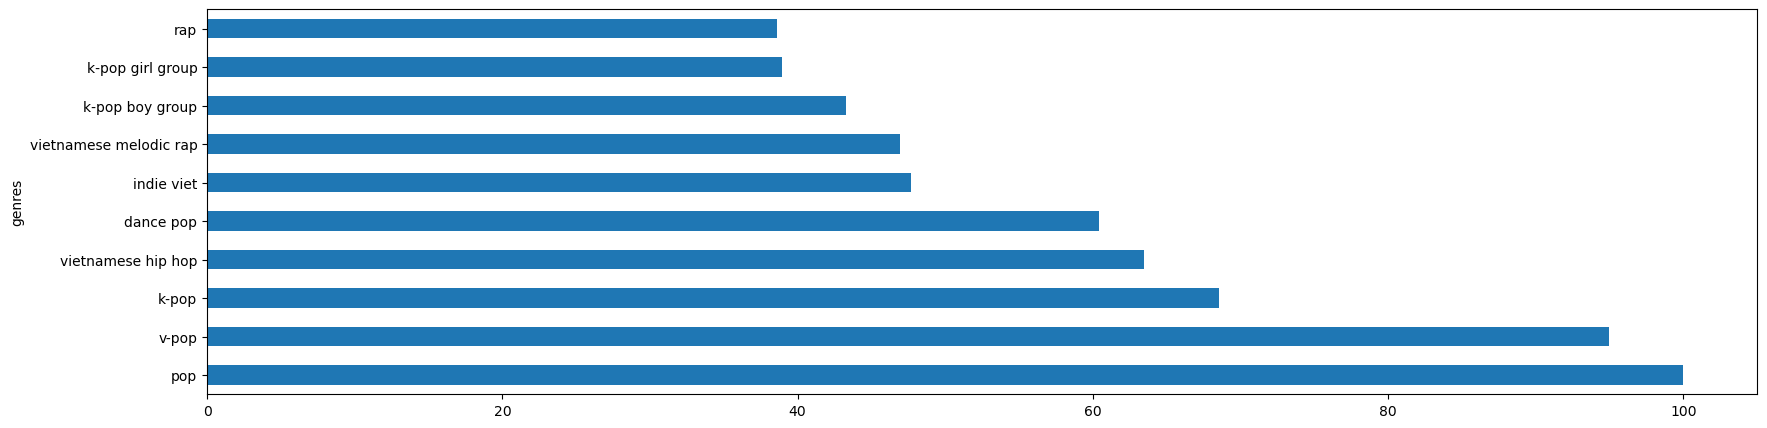

In [107]:
genre_trend.nlargest(n=10, columns='rating')['rating'].plot.barh(figsize=(20, 5))

### <b><u>Question</u>: Gu âm nhạc thịnh hành thay đổi như nào sau từng tháng/năm (VD: tháng 1 năm 2022 thì genre nào có popularity cao nhất/hoặc xuất hiện nhiều nhất)</b>

In [108]:
df['month'] = pd.DatetimeIndex(df['released_date']).month
df['year'] = pd.DatetimeIndex(df['released_date']).year
df.head()

/tmp/ipykernel_4153/3821007479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.DatetimeIndex(df['released_date']).month
/tmp/ipykernel_4153/3821007479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = pd.DatetimeIndex(df['released_date']).year


,id,name,artist,genres,artist_followers,artist_popularity,markets,album,released_date,album_popularity,duration,explicit,popularity,month,year
0,1RDvyOk4WtPCtoqciJwVn8,Dreamers [Music from the FIFA World Cup Qatar ...,"Jung Kook,BTS,FIFA Sound","[k-pop boy group, k-pop]","5382641,58715441,167875","80,92,77",183,Dreamers [Music from the FIFA World Cup Qatar ...,2022-11-20,81,201391,False,92,11,2022
2,7bFFUPBiF15n8m8RziqS4o,dự báo thời tiết hôm nay mưa,GREY D,[v-pop],39690,56,182,dự báo thời tiết hôm nay mưa – Maxi Single,2022-11-22,52,281493,False,62,11,2022
3,4QjxvzEFwb63NZ1pp3wvHy,Chết Trong Em,Thịnh Suy,"[vietnamese singer-songwriter, v-pop]",359817,54,183,Chết Trong Em,2022-10-31,50,256663,False,62,10,2022
4,5p8ThxM2OhJ0igfxkz0Z1q,Wild Flower (with youjeen),RM,[k-rap],12005881,81,183,Indigo,2022-12-02,85,273499,False,88,12,2022
6,5yrPkBvOBvqfSjDhoRzDlO,Tại Vì Sao,RPT MCK,"[vietnamese trap, vietnamese hip hop, vietname...",271841,56,183,Tại Vì Sao,2022-09-23,52,203111,True,64,9,2022


In [170]:
song_release_df = df.explode('genres').loc[:, ['name', 'genres', 'popularity', 'year', 'month']].reset_index(drop=True)
genre_release = song_release_df.groupby(['year', 'month']).max()
genre_release

name                        genres  \
year month                                                                 
2020 1                          너를 사랑하고 있어                  vocal trance   
     2                                  시작                 zhongguo feng   
     3                                  少年                     weirdcore   
     4                                旧梦一场                     viral pop   
     5                                  情人               vietnamese trap   
     6                                爱,存在                     viral rap   
     7                                飞鸟和蝉  vietnamese singer-songwriter   
     8                                 燕无歇                     weirdcore   
     9                                 起风了                     viral pop   
     10                                紅蓮華                  zhenskiy rep   
     11                          parachute                     viral pop   
     12                                沈园外                 zhongguo feng   
2021 1                                  群青                     viral rap   
     2                                  沦陷                west coast rap   
     3                                西楼别序                 zhongguo feng   
     4                     输入法打可爱按第五 - 纯享版                     viral pop   
     5                                  不如                     viral rap   
     6                              好きだから。                   white noise   
     7                                飞鸟和蝉                     viral pop   
     8                                时光洪流                     viral rap   
     9                            Độ Tộc 2                     viral pop   
     10                         Đừng Bỏ Lỡ                   white noise   
     11                                踊り子                     viral rap   
     12                                 逆夢                     viral pop   
2022 1                            snowfall               vietnamese trap   
     2                 Đau Nhất Là Lặng Im               vietnamese trap   
     3         Trên Tình Bạn Dưới Tình Yêu  vietnamese singer-songwriter   
     4                            With you        vietnamese melodic rap   
     5      hai mươi hai (22) [feat. AMEE]        vietnamese melodic rap   
     6        vaicaunoicokhiennguoithaydoi                     viral pop   
     7                  Đã Lỡ Yêu Em Nhiều  vietnamese singer-songwriter   
     8                đứa nào làm em buồn?                west coast rap   
     9                    Đáp Án Cuối Cùng               vietnamese trap   
     10                        golden hour                     viral pop   
     11                           Đơn Giản                     viral pop   
     12       you should see me in a crown  vietnamese singer-songwriter   

            popularity  
year month              
2020 1              89  
     2              83  
     3              91  
     4              84  
     5              89  
     6              83  
     7              84  
     8              87  
     9              82  
     10             84  
     11             84  
     12             83  
2021 1              80  
     2              80  
     3              87  
     4              83  
     5              87  
     6              87  
     7              88  
     8              87  
     9              89  
     10             87  
     11             85  
     12             89  
2022 1              90  
     2              80  
     3              93  
     4              88  
     5              95  
     6              90  
     7              94  
     8              97  
     9             100  
     10             97  
     11             92  
     12             91

<AxesSubplot:>

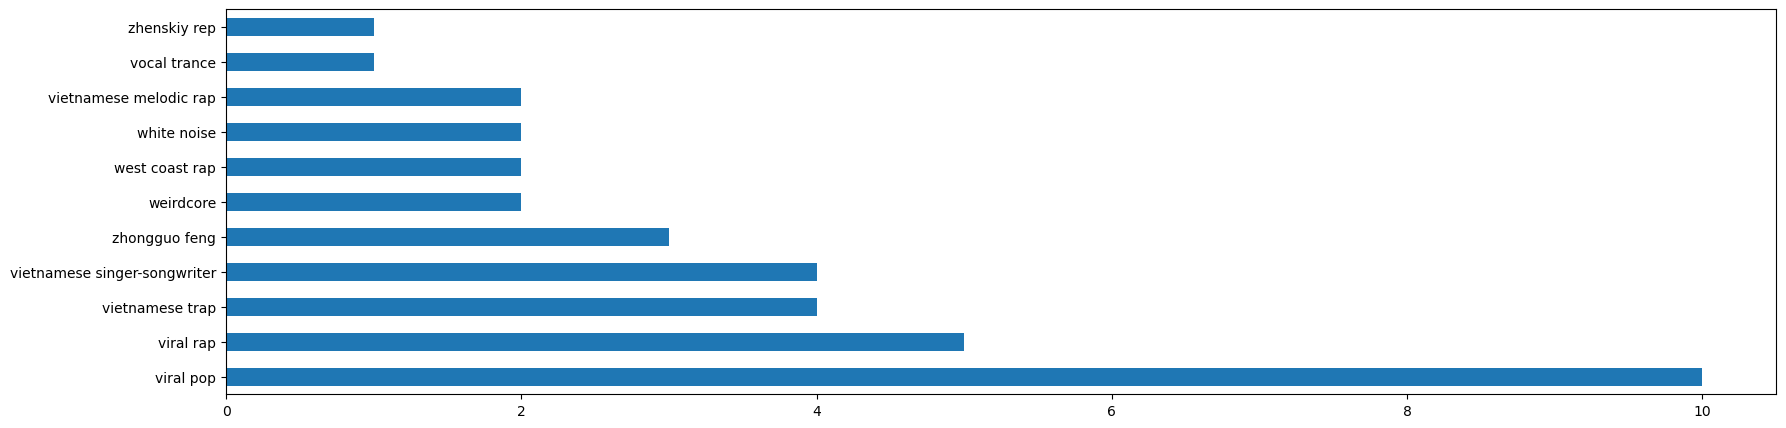

In [168]:
genre_release['genres'].value_counts().plot.barh(figsize=(20, 5))

In [142]:
genre_release_most = song_release_df.groupby(['year', 'month'])['genres'].agg(pd.Series.mode).to_frame()
genre_release_most

genres
year month                             
2020 1                            v-pop
     2                            k-pop
     3                              pop
     4                            v-pop
     5                            v-pop
     6                            v-pop
     7                            v-pop
     8                            v-pop
     9                            v-pop
     10                           v-pop
     11                           v-pop
     12                           v-pop
2021 1                            v-pop
     2                            v-pop
     3                            v-pop
     4                            v-pop
     5                            v-pop
     6                            v-pop
     7                     [pop, v-pop]
     8                            v-pop
     9                            v-pop
     10                             pop
     11                             pop
     12                           v-pop
2022 1      [v-pop, vietnamese hip hop]
     2                            v-pop
     3                            v-pop
     4                            v-pop
     5                            v-pop
     6                            v-pop
     7                            v-pop
     8                            v-pop
     9                            v-pop
     10                           v-pop
     11                           v-pop
     12                             pop

<AxesSubplot:ylabel='genres'>

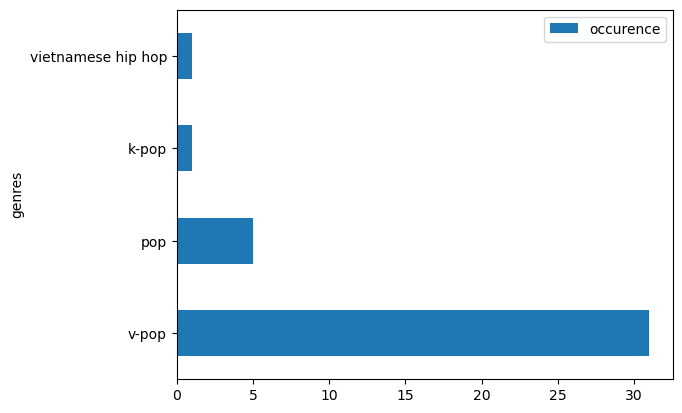

In [164]:
genre_release_most.explode('genres').value_counts().reset_index(name='occurence').plot.barh(x='genres', y='occurence')